**Piramide Gausiana**

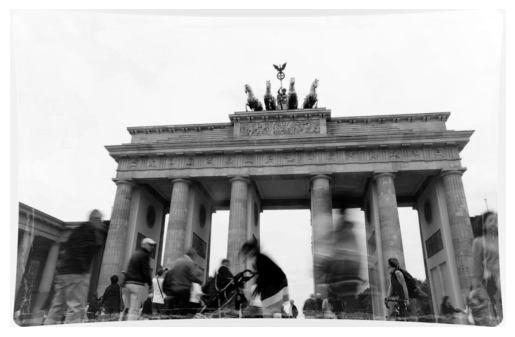

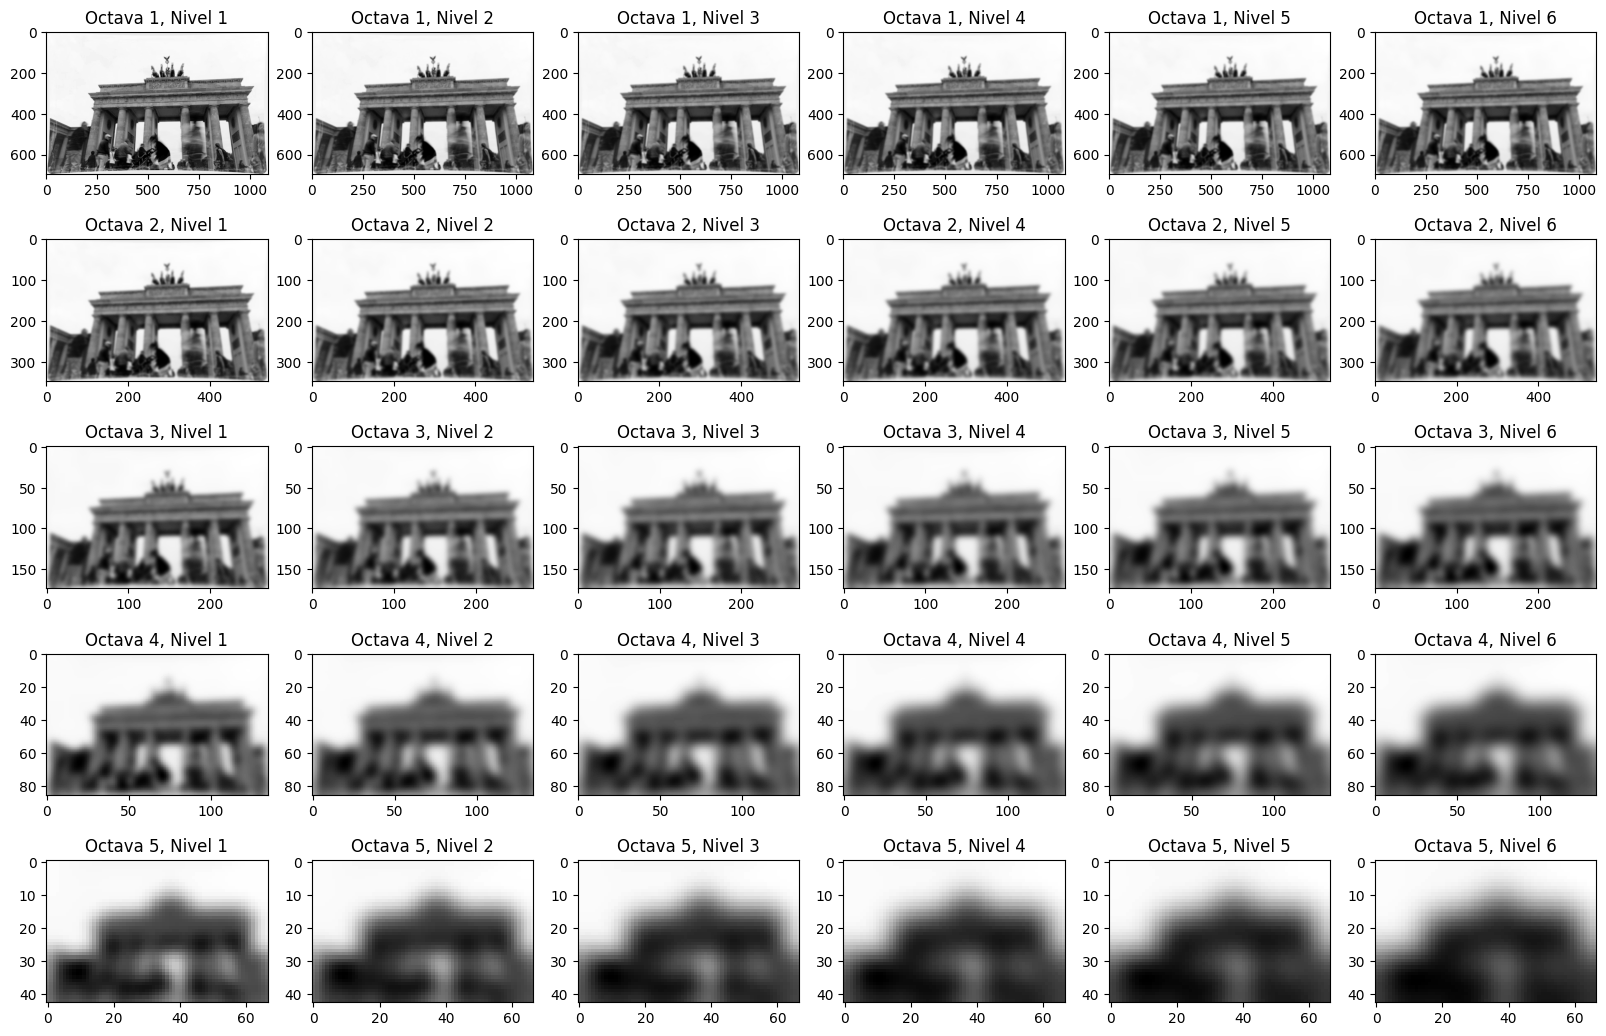

In [26]:
import numpy as np
from scipy.ndimage import convolve
import cv2
from matplotlib import pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

def gaussian_filter(sigma):
	size = 2*np.ceil(3*sigma)+1
	x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
	g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
	return g/g.sum()

def generate_octave(init_level, escalas, sigma):
    octave = [init_level]
    k = 2 ** (1/escalas)
    # Generar el kernel gaussiano
    kernel = gaussian_filter(k * sigma)
    for _ in range(escalas):
        # Convolucionar el nivel anterior con el kernel gaussiano
        next_level = convolve(octave[-1], kernel, mode='nearest')
        octave.append(next_level)
    return octave

def generate_gaussian_pyramid(image, octaves, scales, sigma):
    pyramid = []
    for _ in range(octaves):
        octave = generate_octave(image, scales, sigma)
        pyramid.append(octave)
        # La siguiente imagen de la pirámide es la imagen de nivel 3 de la octava anterior
        image = octave[-2]
        # Reducir la resolución para la siguiente iteración
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    return pyramid

imagen = cv2.imread('prueba1.jpg')
img = np.array(imagen)
img = rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.axis('off')


escalas = 6  # número de escalas en la octava
sigma = 1.6
octavas = 5  # número de octavas en la pirámide

gaussian_pyramid = generate_gaussian_pyramid(img, octavas, escalas, sigma)

# Visualizar la pirámide Gaussiana
fig, axs = plt.subplots(octavas, escalas, figsize=(20, 13))
for i in range(octavas):
    for j in range(escalas):
        axs[i, j].imshow(gaussian_pyramid[i][j], cmap='gray')
        #axs[i, j].axis('off')
        axs[i, j].set_title(f'Octava {i+1}, Nivel {j+1}')
plt.show()

**Diferencia Gausiana DoG**

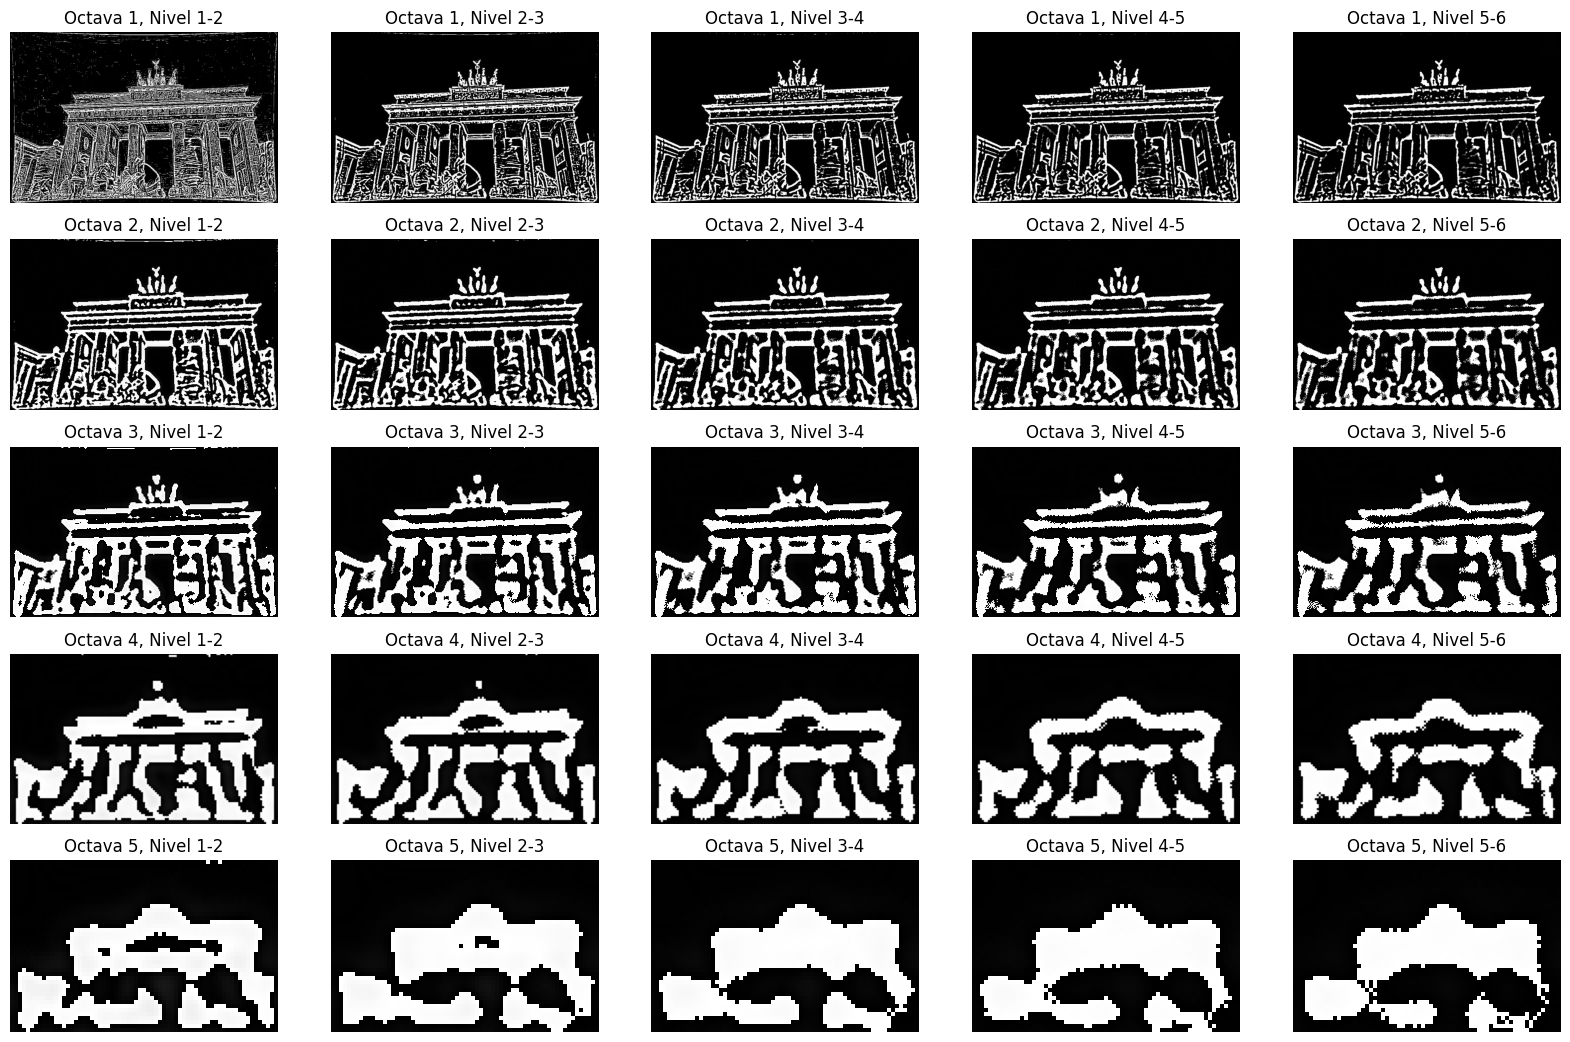

In [27]:
def generate_dog_pyramid(gaussian_pyramid):
    dog_pyramid = []
    for octave in gaussian_pyramid:
        dog_octave = [octave[i] - octave[i+1] for i in range(len(octave) - 1)]
        dog_pyramid.append(dog_octave)
    return dog_pyramid

# Construir la pirámide DoG
dog_pyramid = generate_dog_pyramid(gaussian_pyramid)

# Visualizar la pirámide DoG
fig, axs = plt.subplots(octavas, escalas - 1, figsize=(20, 13))
for i in range(octavas):
    for j in range(escalas - 1):
        axs[i, j].imshow(dog_pyramid[i][j], cmap='gray')
        axs[i, j].set_title(f'Octava {i+1}, Nivel {j+1}-{j+2}')
        axs[i, j].axis('off')
plt.show()

**detección de keypoints**

[(962, 0, 1), (963, 0, 1), (964, 0, 1), (962, 1, 1), (963, 1, 1), (964, 1, 1), (588, 142, 1), (594, 142, 1), (588, 143, 1), (589, 143, 1), (591, 143, 1), (592, 143, 1), (594, 143, 1), (595, 143, 1), (591, 144, 1), (592, 144, 1), (594, 144, 1), (591, 145, 1), (592, 145, 1), (594, 145, 1), (591, 146, 1), (592, 146, 1), (594, 146, 1), (591, 147, 1), (592, 147, 1), (593, 147, 1), (594, 147, 1), (595, 147, 1), (588, 148, 1), (589, 148, 1), (591, 148, 1), (592, 148, 1), (594, 148, 1), (595, 148, 1), (620, 151, 1), (620, 152, 1), (617, 155, 1), (618, 155, 1), (615, 156, 1), (616, 156, 1), (617, 156, 1), (618, 156, 1), (615, 158, 1), (670, 163, 1), (667, 164, 1), (668, 164, 1), (670, 164, 1), (667, 165, 1), (668, 165, 1), (670, 165, 1), (562, 166, 1), (660, 171, 1), (655, 186, 1), (648, 190, 1), (649, 190, 1), (650, 190, 1), (651, 190, 1), (664, 190, 1), (665, 190, 1), (648, 191, 1), (649, 191, 1), (650, 191, 1), (603, 192, 1), (649, 193, 1), (650, 194, 1), (651, 194, 1), (652, 194, 1), (524, 

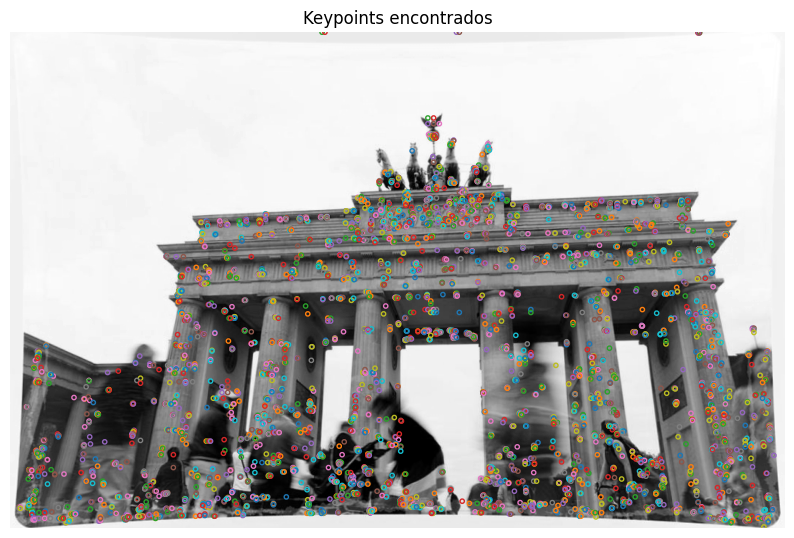

In [22]:
import cv2
import matplotlib.pyplot as plt

def find_keypoints(dog_pyramid, threshold=0.07):
    keypoints = []
    for octave_index, octave in enumerate(dog_pyramid):
        for scale_index, (dog_level1, dog_level2) in enumerate(zip(octave[:-1], octave[1:])):
            # Encontrar los puntos clave usando el detector de esquinas Harris
            harris_response = cv2.cornerHarris(dog_level2, blockSize=5, ksize=3, k=0.03)
            # Filtrar los puntos clave por umbral
            keypoints_indices = np.argwhere(harris_response > threshold)
            for keypoint_index in keypoints_indices:
                y, x = keypoint_index
                keypoints.append((x * (2 ** octave_index), y * (2 ** octave_index), scale_index + 1))
    return keypoints

keypoints = find_keypoints(dog_pyramid)
print(keypoints)
print(f'Encontrados {len(keypoints)} puntos clave.')

cmap = plt.colormaps.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')

for i, (x, y, scale) in enumerate(keypoints):
    color = cmap(i % 10) 
    circle = plt.Circle((x, y), radius=3, color=color, fill=False)
    ax.add_patch(circle)

plt.title('Keypoints encontrados')
plt.axis('off')
plt.show()


**Orientacion**

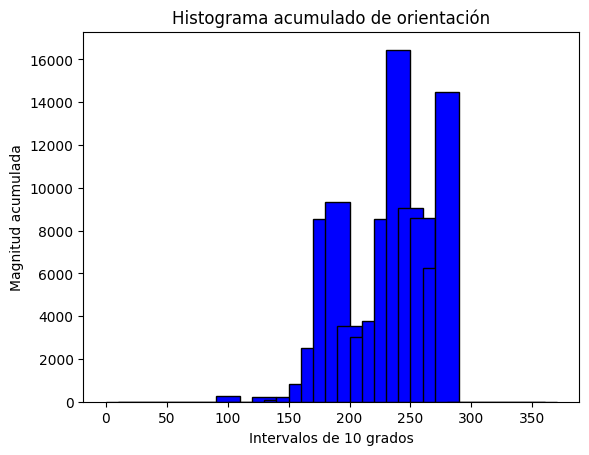

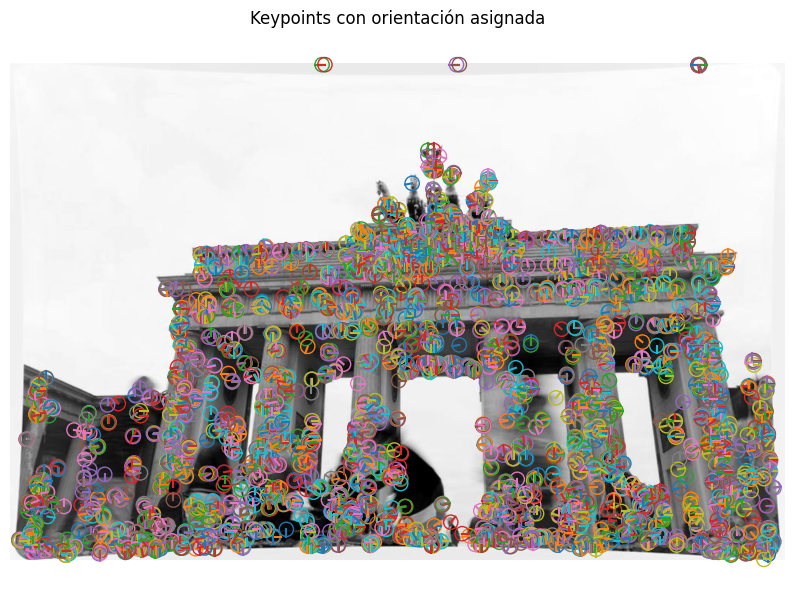

In [23]:
def calculate_gradient_orientation(image, sigma):
    smoothed_image = cv2.GaussianBlur(image, (0, 0), sigma)
    dx = cv2.Sobel(smoothed_image, cv2.CV_64F, 1, 0, ksize=5)
    dy = cv2.Sobel(smoothed_image, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = np.sqrt(dx**2 + dy**2)
    orientation = np.arctan2(dy, dx)
    return magnitude, orientation


def assign_orientation(keypoints, img_gray):
    oriented_keypoints = []
    histogram = np.zeros(36)

    for x, y, scale in keypoints:
        radius = int(3 * scale)
        region = img_gray[max(0, int(y) - radius):int(y) + radius + 1,
                          max(0, int(x) - radius):int(x) + radius + 1]
        # Calcular el histograma de orientación
        magnitude, orientation = calculate_gradient_orientation(region, sigma=1.5*scale)
        # Crear un histograma ponderado por la magnitud del gradiente
        histogram, bin_edges = np.histogram(orientation, bins=36, range=(-np.pi, np.pi), weights=magnitude)
        # Encontrar la orientación dominante en el histograma (valor máximo)
        dominant_orientation = bin_edges[np.argmax(histogram)]
        # Añadir el punto clave con la orientación asignada a la lista
        oriented_keypoints.append((x, y, scale, dominant_orientation))
    bin_edges = np.linspace(0, 360, 37)
    plt.figure()
    plt.bar(bin_edges[:-1], histogram, width=20, align='edge', color='blue', edgecolor='black')
    plt.title('Histograma acumulado de orientación')
    plt.xlabel('Intervalos de 10 grados')
    plt.ylabel('Magnitud acumulada')
    plt.show()
    return oriented_keypoints

oriented_keypoints = assign_orientation(keypoints, img)

# Visualizar la imagen con los puntos clave y orientaciones
cmap = plt.colormaps.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, cmap='gray')

for i, (x, y, scale, orientation) in enumerate(oriented_keypoints):
    color = cmap(i % 10)
    circle = plt.Circle((x, y), radius=10, color=color, fill=False)
    ax.add_patch(circle)

    # Dibujar la orientación como una línea en la dirección del gradiente
    line_length = 10
    line_x = x + line_length * np.cos(orientation)
    line_y = y + line_length * np.sin(orientation)
    ax.plot([x, line_x], [y, line_y], color=color)

plt.title('Keypoints con orientación asignada')
plt.axis('off')
plt.show()

